In [1]:
import ijson
import numpy as np
import json
from decimal import Decimal
import json
import time
import torch
import warnings
import numpy as np
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns


In [2]:
import matplotlib.pyplot as plt

In [3]:
datos = []

def cargar_datos_json(json_path, num_jets=22500, num_constituents=10):
    with open(json_path, 'r') as f:
        data = json.load(f)

    eventos = []
    for i, evento in enumerate(data[:num_jets]):
        jet_pt, jet_eta, jet_phi, jet_mass = evento['jet_kinematics']
        constituents = evento['PFCands']

        # Calcular pT para cada constituyente
        constituents = np.array(constituents)
        px = constituents[:, 0]
        py = constituents[:, 1]
        pt = np.sqrt(px**2 + py**2)

        # Índices de los 10 con mayor pT
        indices_ordenados = np.argsort(pt)[::-1][:num_constituents]
        top_cands = constituents[indices_ordenados]

        # Convertir cada uno a formato usado en el circuito
        top_constituents = []
        for cand in top_cands:
            px, py, pz, E = cand[0:4]
            pt = np.sqrt(px**2 + py**2)
            p_total = np.sqrt(px**2 + py**2 + pz**2)
            eta = 0.5 * np.log((p_total + pz) / (p_total - pz + 1e-8))  # evitar división por 0
            phi = np.arctan2(py, px)
            mass = np.sqrt(np.maximum(0, E**2 - (px**2 + py**2 + pz**2)))#En caso de que de masa negativa la pone a cero
            top_constituents.append({
                'pt': pt,
                'eta': eta,
                'phi': phi,
                'mass': mass,
                'energy': E,
            })

        eventos.append({
            'pt_jet': jet_pt,
            'eta_jet': jet_eta,
            'phi_jet': jet_phi,
            'mass_jet': jet_mass,
            'constituents': top_constituents
        })

    return eventos

#datos = cargar_datos_json('runG_batch0_reducido_22500.json')
#Para correrlo desde el mac en local
datos = cargar_datos_json('/Volumes/usb_MCarou/runG_batch0_reducido_22500.json')

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/usb_MCarou/runG_batch0_reducido_22500.json'

In [ ]:
print(len(datos))
print((datos[0]['constituents'][0]['pt']))

22500
140.2500004129156


In [ ]:
df1 = pd.DataFrame(datos)
df1

,pt_jet,eta_jet,phi_jet,mass_jet,constituents
0,408.75,0.950439,2.559570,10.914062,"[{'pt': 140.2500004129156, 'eta': 0.9534912076..."
1,353.25,-0.899414,-0.696411,104.875000,"[{'pt': 67.50000190873924, 'eta': -0.766845667..."
2,385.50,2.114258,0.822266,4.828125,"[{'pt': 112.43750079899348, 'eta': 2.096679660..."
3,371.25,2.100586,-2.334473,25.359375,"[{'pt': 69.62500171304517, 'eta': 2.0537109113..."
4,426.75,0.202057,1.660400,5.500000,"[{'pt': 152.7500023117988, 'eta': 0.2078247094..."
...,...,...,...,...,...
22495,462.75,-1.389648,-0.667358,33.843750,"[{'pt': 78.81249867197027, 'eta': -1.366455113..."
22496,343.75,0.615356,-2.423828,9.367188,"[{'pt': 109.7500000954542, 'eta': 0.6206054796..."
22497,458.25,1.955811,-1.871338,84.312500,"[{'pt': 97.06249850935771, 'eta': 1.9304199598..."
22498,317.00,-0.441284,0.873169,71.000000,"[{'pt': 55.65624911915513, 'eta': -0.303588866..."


In [ ]:
dataGraph = {'pt': [], 'eta': [], 'phi': [], 'mass': [], 'energy': []}

for i in range(len(datos)):
    num_jets = len(datos[i]['constituents'])
    for j in range(num_jets):
        dataGraph['pt'].append(datos[i]['constituents'][j]['pt'])
        dataGraph['eta'].append(datos[i]['constituents'][j]['eta'])
        dataGraph['phi'].append(datos[i]['constituents'][j]['phi'])
        dataGraph['mass'].append(datos[i]['constituents'][j]['mass'])
        dataGraph['energy'].append(datos[i]['constituents'][j]['energy'])


df2 = pd.DataFrame(dataGraph)
df2

,pt,eta,phi,mass,energy
0,140.250000,0.953491,2.535645,0.000000,208.982727
1,41.437498,0.955689,2.609863,0.000000,61.845627
2,26.312500,0.944702,2.564453,0.139704,38.953835
3,21.484375,0.971558,2.568359,0.139125,32.447609
4,19.781251,0.954224,2.563965,0.139367,29.491848
...,...,...,...,...,...
224916,5.925781,0.662354,-1.228516,0.139521,7.275198
224917,5.390625,0.979492,-1.888916,0.139544,8.191179
224918,4.421875,0.355408,-1.500000,0.139528,4.706170
224919,4.335937,0.863037,-1.968750,0.139533,6.055070


In [ ]:
datos
pt = []
eta = []
phi = []
mass = []
energy = []

for i in range(len(datos)):
    num_jets = len(datos[i]['constituents'])
    for j in range(num_jets):
        pt.append(datos[i]['constituents'][j]['pt'])
        eta.append(datos[i]['constituents'][j]['eta'])
        phi.append(datos[i]['constituents'][j]['phi'])
        mass.append(datos[i]['constituents'][j]['mass'])
        energy.append(datos[i]['constituents'][j]['energy'])

In [ ]:
num_ele = range(len(pt))
num_ele

range(0, 224921)

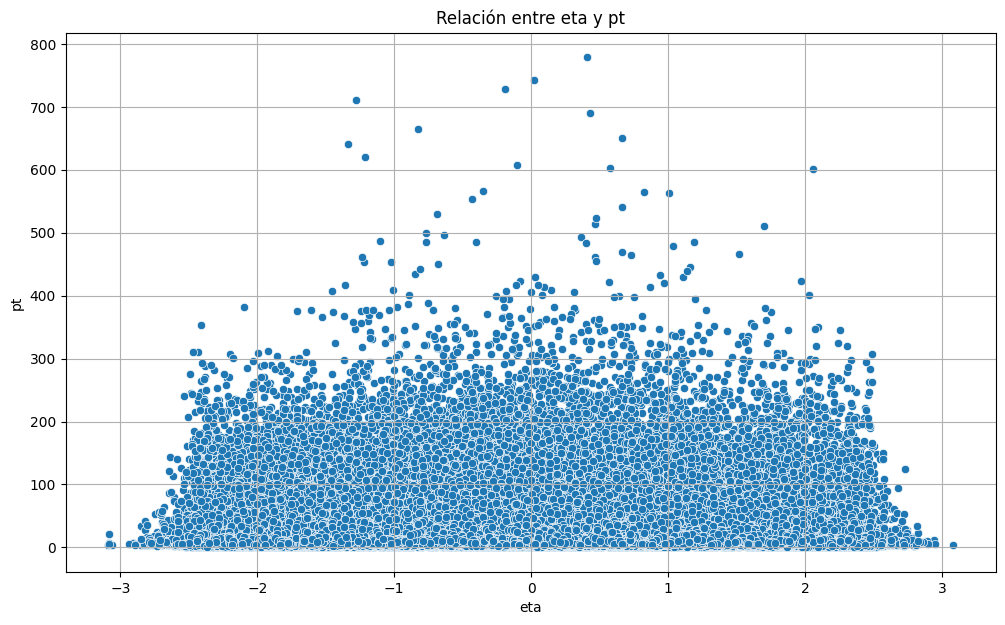

In [ ]:
plt.figure(figsize=(12,7))
sns.scatterplot(x='eta', y='pt', data=df2)
plt.xlabel('eta')
plt.ylabel('pt')
plt.title('Relación entre eta y pt')
plt.grid(True)
plt.show()

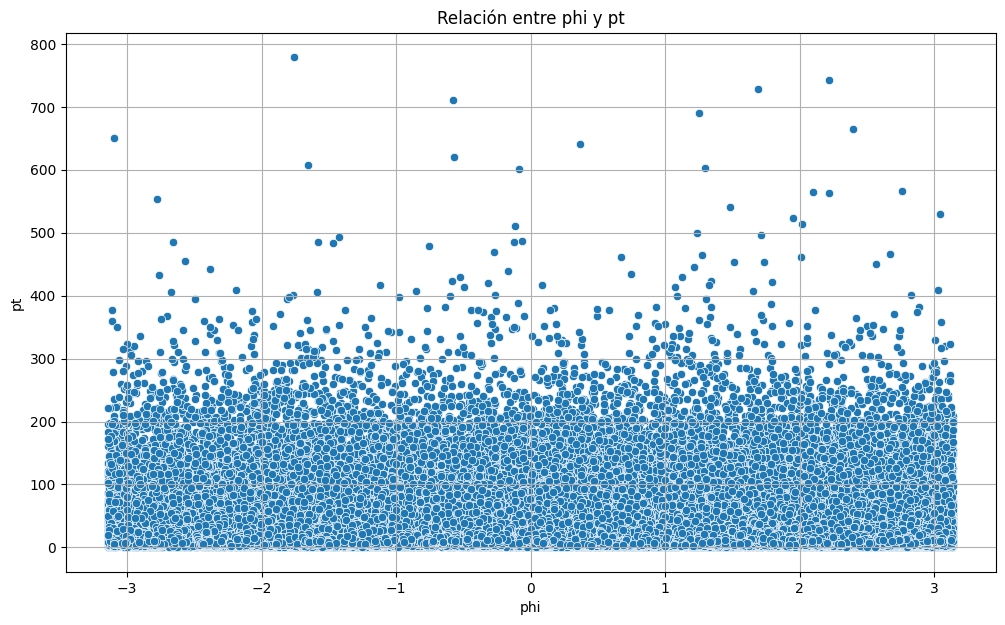

In [ ]:
plt.figure(figsize=(12,7))
sns.scatterplot(x='phi', y='pt', data=df2)
plt.xlabel('phi')
plt.ylabel('pt')
plt.title('Relación entre phi y pt')
plt.grid(True)
plt.show()

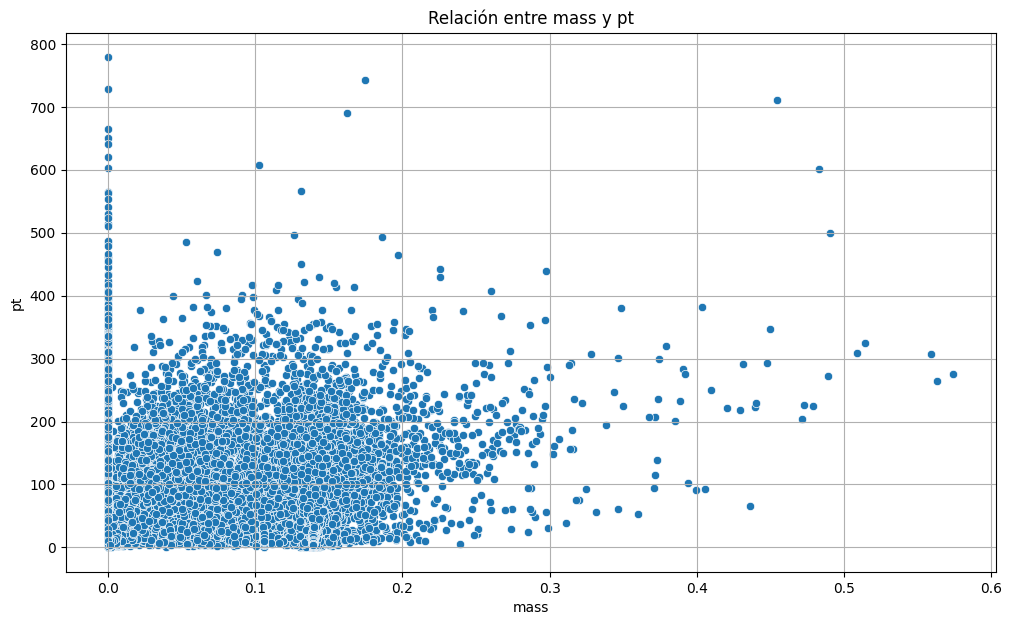

In [ ]:
plt.figure(figsize=(12,7))
sns.scatterplot(x='mass', y='pt', data=df2)
plt.xlabel('mass')
plt.ylabel('pt')
plt.title('Relación entre mass y pt')
plt.grid(True)
plt.show()

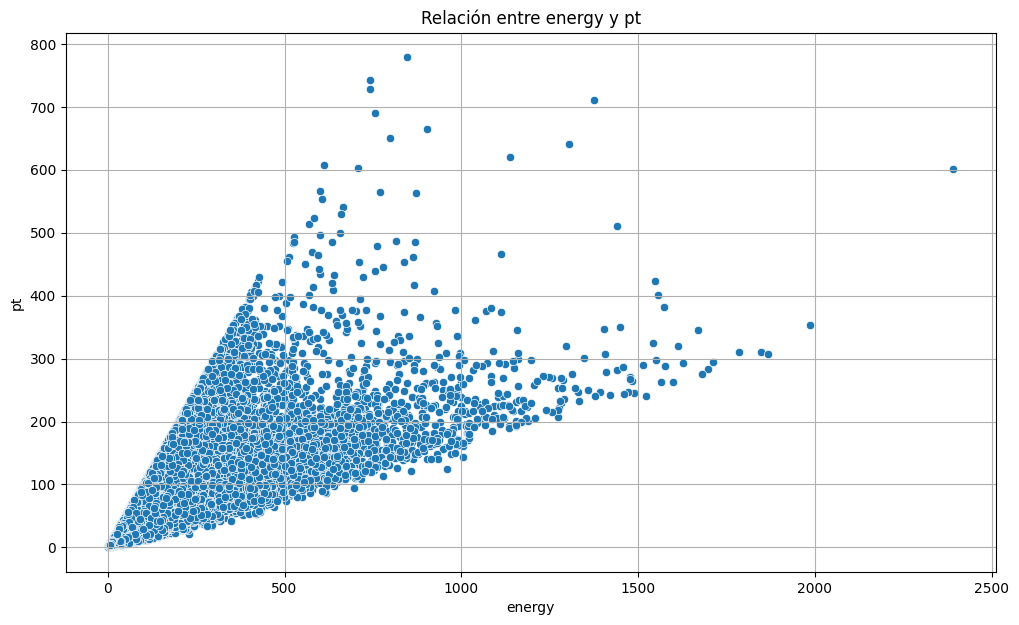

In [ ]:
plt.figure(figsize=(12,7))
sns.scatterplot(x='energy', y='pt', data=df2)
plt.xlabel('energy')
plt.ylabel('pt')
plt.title('Relación entre energy y pt')
plt.grid(True)
plt.show()

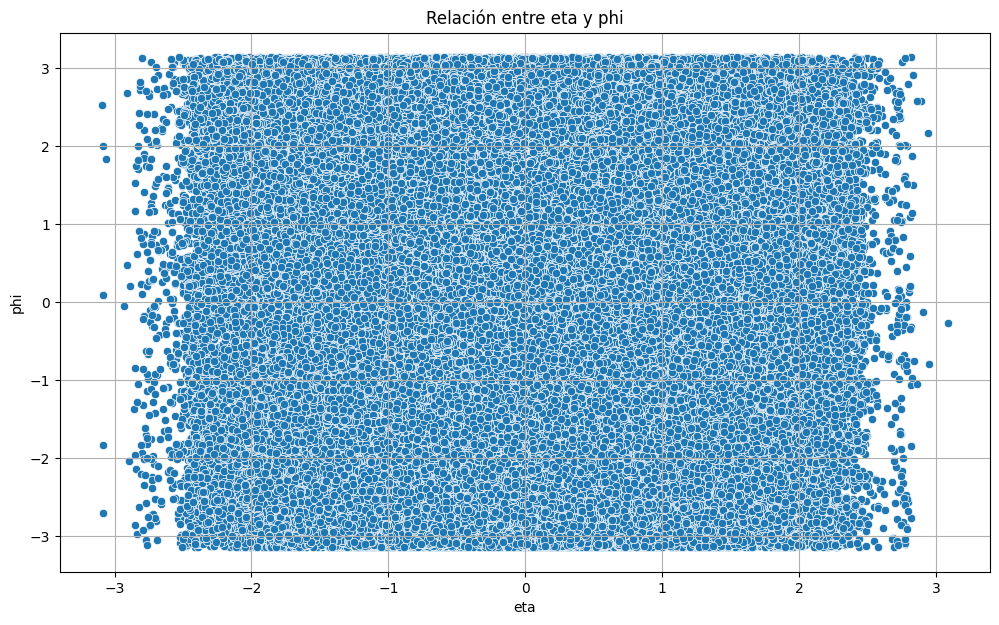

In [ ]:
plt.figure(figsize=(12,7))
sns.scatterplot(x='eta', y='phi', data=df2)
plt.xlabel('eta')
plt.ylabel('phi')
plt.title('Relación entre eta y phi')
plt.grid(True)
plt.show()

---

---

---

---

---

<Axes: xlabel='pt', ylabel='eta'>

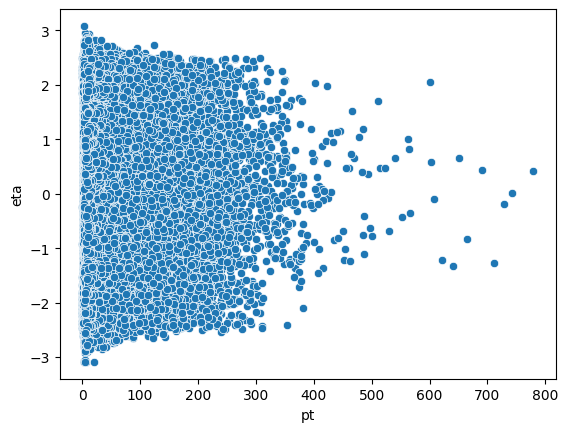

In [ ]:
sns.scatterplot(x="pt", y="eta", data=df2)

<Axes: xlabel='pt', ylabel='phi'>

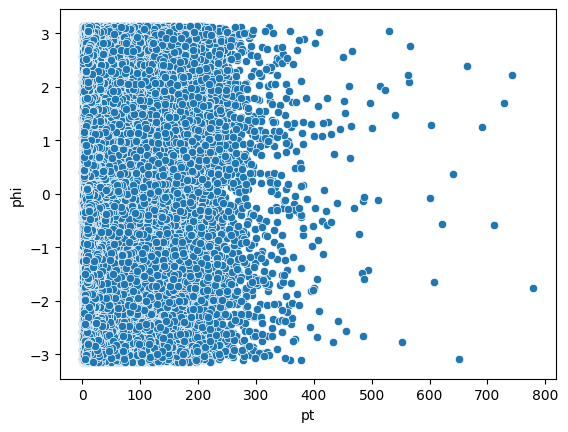

In [ ]:
sns.scatterplot(x="pt", y="phi", data=df2)

<Axes: xlabel='pt', ylabel='mass'>

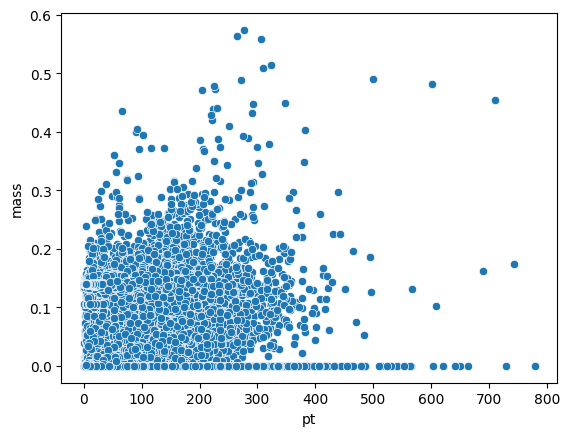

In [ ]:
sns.scatterplot(x="pt", y="mass", data=df2)

A value of r = 0 indicates no correlation (the variables are independent) and r = -1 indicates the variables are inversely correlated (an increase in one variable is associated with a decrease in the other). The Person Result first value correspond to r

In [ ]:
from scipy import stats
stats.pearsonr(df2['pt'], df2['eta'])

PearsonRResult(statistic=-0.0006967262788352885, pvalue=0.7410777420119885)

In [ ]:
cormat = df2.corr()
round(cormat,2)

,pt,eta,phi,mass
pt,1.00,-0.00,0.00,-0.09
eta,-0.00,1.00,-0.01,-0.00
phi,0.00,-0.01,1.00,-0.01
mass,-0.09,-0.00,-0.01,1.00


<Axes: >

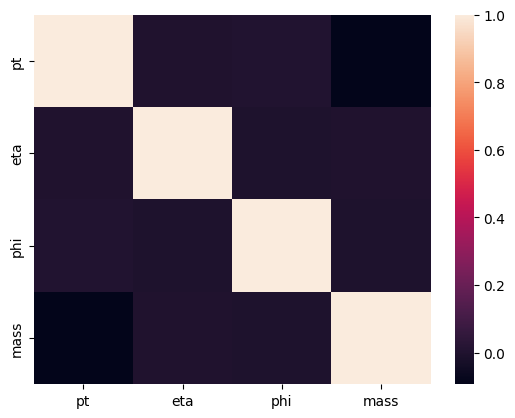

In [ ]:
sns.heatmap(cormat)

---

---

---

---

In [ ]:
rows = []

for evento in datos:
    pt_jet = evento['pt_jet']
    eta_jet = evento['eta_jet']
    phi_jet = evento['phi_jet']
    mass_jet = evento['mass_jet']
    
    for i, cand in enumerate(evento['constituents']):
        rows.append({
            'jet_pt': pt_jet,
            'jet_eta': eta_jet,
            'jet_phi': phi_jet,
            'jet_mass': mass_jet,
            'cand_pt': cand['pt'],
            'cand_eta': cand['eta'],
            'cand_phi': cand['phi'],
            'cand_mass': cand['mass'],
            'cand_energy': cand['energy'],
            'cand_idx': i+1  # índice del constituyente (1-10)
        })

df = pd.DataFrame(rows)


kde=True es un parámetro de Seaborn (y también en sns.histplot) que significa:

**Kernel Density Estimate (Estimación de Densidad por Kernel)**

En un histograma normal, vemos barras que cuentan cuántos valores caen en cada rango.

Con **kde=True**, además de las barras, Seaborn dibuja una curva suave que estima la densidad continua de los datos, como una versión suavizada del histograma.

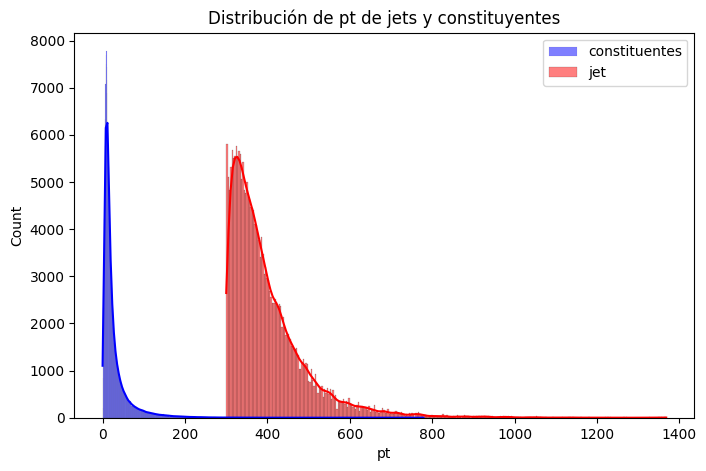

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['cand_pt'], color='blue', label='constituentes', kde=True)
sns.histplot(df['jet_pt'], color='red', label='jet', kde=True)
plt.xlabel('pt')
plt.legend()
plt.title('Distribución de pt de jets y constituyentes')
plt.show()

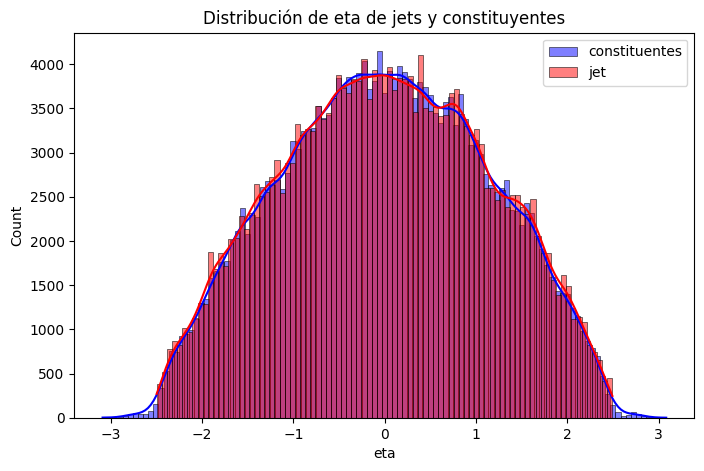

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['cand_eta'], color='blue', label='constituentes', kde=True)
sns.histplot(df['jet_eta'], color='red', label='jet', kde=True)
plt.xlabel('eta')
plt.legend()
plt.title('Distribución de eta de jets y constituyentes')
plt.show()

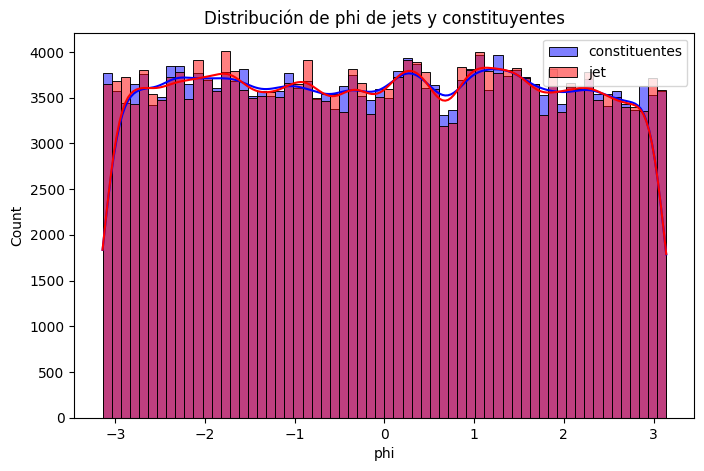

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['cand_phi'], color='blue', label='constituentes', kde=True)
sns.histplot(df['jet_phi'], color='red', label='jet', kde=True)
plt.xlabel('phi')
plt.legend()
plt.title('Distribución de phi de jets y constituyentes')
plt.show()

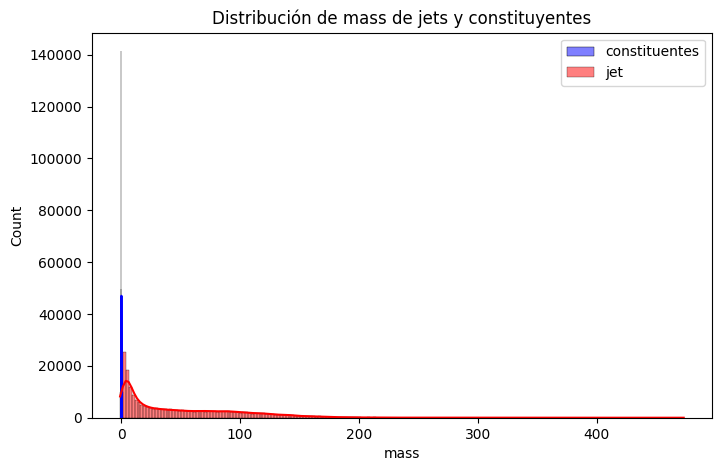

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['cand_mass'], color='blue', label='constituentes', kde=True)
sns.histplot(df['jet_mass'], color='red', label='jet', kde=True)
plt.xlabel('mass')
plt.legend()
plt.title('Distribución de mass de jets y constituyentes')
plt.show()

The **standard correlation coefficient**, most commonly Pearson's r, is a statistical measure that quantifies the strength and direction of a linear relationship between two variables, ranging from -1 (perfect negative correlation) to +1 (perfect positive correlation), with 0 indicating no linear relationship.

In [77]:
cormat2 = df.corr()
round(cormat2,2)

,jet_pt,jet_eta,jet_phi,jet_mass,cand_pt,cand_eta,cand_phi,cand_mass,cand_energy,cand_idx
jet_pt,1.00,0.00,-0.00,0.10,0.22,0.00,-0.01,0.01,0.13,0.00
jet_eta,0.00,1.00,-0.01,0.01,-0.00,0.99,-0.01,-0.00,-0.00,-0.00
jet_phi,-0.00,-0.01,1.00,-0.01,0.00,-0.01,0.92,-0.00,0.00,0.00
jet_mass,0.10,0.01,-0.01,1.00,-0.06,0.01,-0.00,-0.02,-0.08,0.00
cand_pt,0.22,-0.00,0.00,-0.06,1.00,-0.00,0.00,-0.09,0.80,-0.63
cand_eta,0.00,0.99,-0.01,0.01,-0.00,1.00,-0.01,-0.00,-0.00,-0.00
cand_phi,-0.01,-0.01,0.92,-0.00,0.00,-0.01,1.00,-0.01,0.00,0.00
cand_mass,0.01,-0.00,-0.00,-0.02,-0.09,-0.00,-0.01,1.00,-0.05,0.05
cand_energy,0.13,-0.00,0.00,-0.08,0.80,-0.00,0.00,-0.05,1.00,-0.50
cand_idx,0.00,-0.00,0.00,0.00,-0.63,-0.00,0.00,0.05,-0.50,1.00


<Axes: >

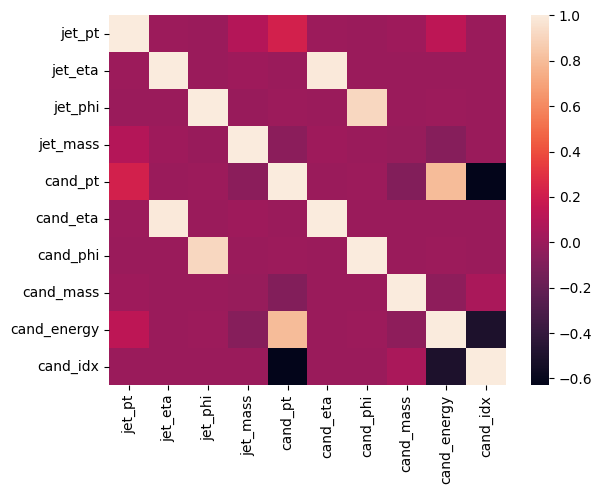

In [78]:
sns.heatmap(cormat2)